### Практическое задание. Урок №4
__1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention__
<br>__2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.__
<br> Выполнено, см. первые ячейки блокнота.
<br>__3. сделать разбиение набора данных не тренировочную и тестовую выборки__
[(см.код)](#goto_1) <br>
__4. сделать feature engineering на ваше усмотрение__ [(см.код)](#goto_2) <br>
__5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями__ [(см.код)](#goto_3)<br>
__6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей__<br>
Здесь в таблице средние значения и стандартное отклонение, данные экспериментов в конце блокнота.<br>
Учитывая разброс можно сделать вывод только о примерно одинаковых результатах всех трех моделей.
<table cellspacing="0" border="0">
	<colgroup span="2" width="85"></colgroup>
	<colgroup width="129"></colgroup>
	<colgroup width="85"></colgroup>
	<tr>
		<td height="17" align="center"><br></td>
		<td colspan=3 align="center"><b>Uplift 10,00%</b></td>
		</tr>
	<tr>
		<td height="17" align="center"><br></td>
		<td align="center">SoloModel</td>
		<td align="center">ClassTransformation</td>
		<td align="center">TwoModels</td>
	</tr>
	<tr>
		<td height="17" align="center">avr</td>
		<td align="center" sdval="0,083" sdnum="1049;">0,083</td>
		<td align="center" sdval="0,066" sdnum="1049;">0,066</td>
		<td align="center" sdval="0,079" sdnum="1049;">0,079</td>
	</tr>
	<tr>
		<td height="17" align="center">std</td>
		<td align="center" sdval="0,017" sdnum="1049;">0,017</td>
		<td align="center" sdval="0,009" sdnum="1049;">0,009</td>
		<td align="center" sdval="0,014" sdnum="1049;">0,014</td>
	</tr>
	<tr>
		<td height="17" align="center"><br></td>
		<td align="center"><br></td>
		<td align="center"><br></td>
		<td align="center"><br></td>
	</tr>
	<tr>
		<td height="17" align="center"><br></td>
		<td colspan=3 align="center"><b>Uplift 20,00%</b></td>
		</tr>
	<tr>
		<td height="17" align="center"><br></td>
		<td align="center">SoloModel</td>
		<td align="center">ClassTransformation</td>
		<td align="center">TwoModels</td>
	</tr>
	<tr>
		<td height="17" align="center">avr</td>
		<td align="center" sdval="0,082" sdnum="1049;">0,082</td>
		<td align="center" sdval="0,075" sdnum="1049;">0,075</td>
		<td align="center" sdval="0,08" sdnum="1049;">0,08</td>
	</tr>
	<tr>
		<td height="17" align="center">std</td>
		<td align="center" sdval="0,01" sdnum="1049;">0,01</td>
		<td align="center" sdval="0,013" sdnum="1049;">0,013</td>
		<td align="center" sdval="0,014" sdnum="1049;">0,014</td>
	</tr>
</table>

<br>__7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево__<br>

К сожалению, мне не удалось установить causalml.inference для JN...

<br>
<br>

__Импортируем нужные библиотеки и предобработаем данные:__

In [19]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd#; pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split

# Чтение данных
df_data = pd.read_csv('HW_4_data/data.csv')

df_clients = pd.read_csv('HW_4_data/clients.csv', index_col='client_id')
df_train = pd.read_csv('HW_4_data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('HW_4_data/uplift_test.csv', index_col='client_id')

df_data.rename(columns = {'conversion' : 'target', 'offer' : 'treatment'}, inplace = True)
df_data['treatment'].loc[(df_data['treatment']=='No Offer')] = 0
df_data['treatment'].loc[(df_data['treatment']!=0)] = 1
df_data.columns

num_feature=['recency', 'history', 'used_discount', 'used_bogo', 'is_referral']

# random_state
rnd_st = 123

__Анализ численных признаков__

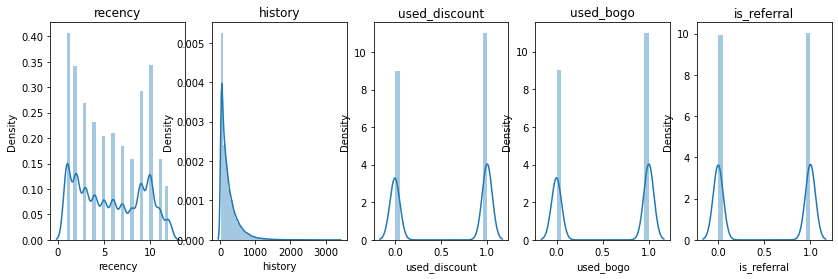

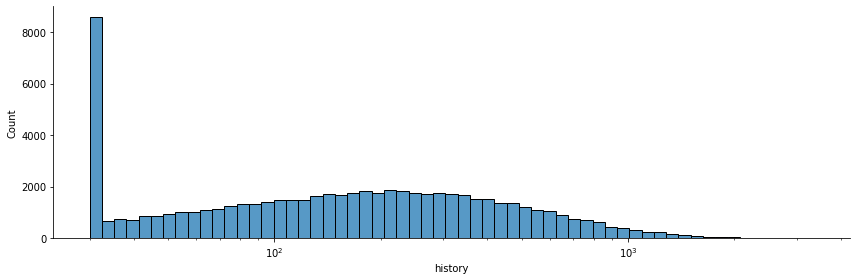

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5,figsize=(14,4))
i=0
for col_name in num_feature:
    sns_plot = sns.distplot(df_data[col_name], ax=axes[i])
    sns_plot.set_title(col_name)
    i += 1
fig = sns_plot.get_figure()

sns_plot = sns.displot(df_data['history'], height=4, aspect=3, log_scale=True)


<a class="anchor" id="goto_2"> <br><br><br><br>



__feature engineering__ <br>
Признак 'history' очень "странный", если исключить значения "29.99", то оставшиеся распределены гладко. Но указанных значений много, просто их выкинуть нельзя. Создадим дополнительный признак 'low_cost_history', который равен "1" при значении 'history'=29.99 и "0" в остальных случаях, а в исходном признаке "странные" значения заменим на выбранные случайно (из того же столбца). Для приведения к "нормальному" виду логарифмируем и стандартизируем значения. <br>
Зам. можно подобрать более аккуратный способ нормализации, но в рамках ДЗ на это нет времени.


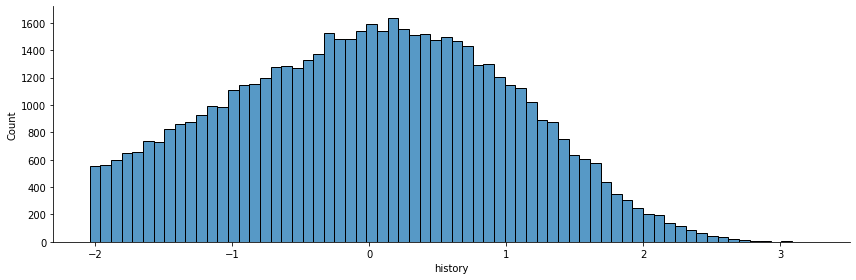

In [21]:
df_data.insert(1, "low_cost_history", 0)
df_data['low_cost_history'].loc[(df_data['history']==29.99)] = 1
df_data['history'].loc[(df_data['low_cost_history']==1)] = df_data['history'].sample(random_state=rnd_st)
df_data['history'] = np.log10(df_data['history'])
df_data['history'] = (df_data['history'] - df_data['history'].mean())/df_data['history'].std()

sns_plot = sns.displot(df_data['history'], height=4, aspect=3, log_scale=False)

<a class="anchor" id="goto_1"> <br><br><br><br>
    
__Разбиение набора данных__

In [22]:

df_features = df_data.copy()

indices_train, indices_test = train_test_split(df_features.index, test_size=0.5, random_state=rnd_st)
indices_learn, indices_valid = train_test_split(indices_train, test_size=0.5, random_state=rnd_st)

X_train = df_features.loc[indices_learn, :]
y_train = df_features.loc[indices_learn, 'target']
treat_train = df_features.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_features.loc[indices_valid, 'target']
treat_val =  df_features.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_features.loc[:, 'target']
treat_train_full = df_features.loc[:, 'treatment']

X_test = df_features.loc[indices_test, :]

X_train = X_train.drop(['treatment', 'target'], axis=1)

In [23]:
# переменные
cat_features = ['zip_code', 'channel']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [24]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

<a class="anchor" id="goto_3"> <br><br><br><br>



__5.1 S-model__

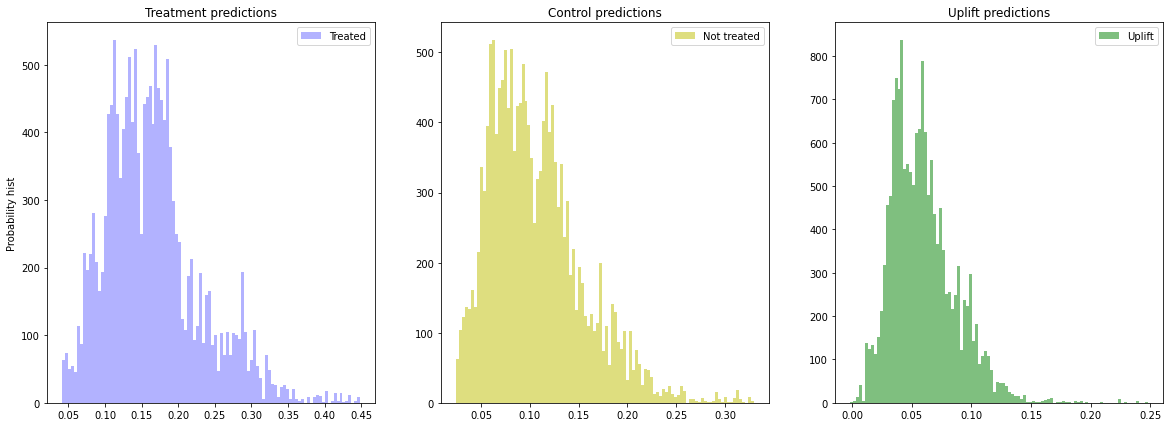

In [25]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=rnd_st, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

models_results['approach'].append('SoloModel')
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(sm_score)
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

__5.2 T-model__

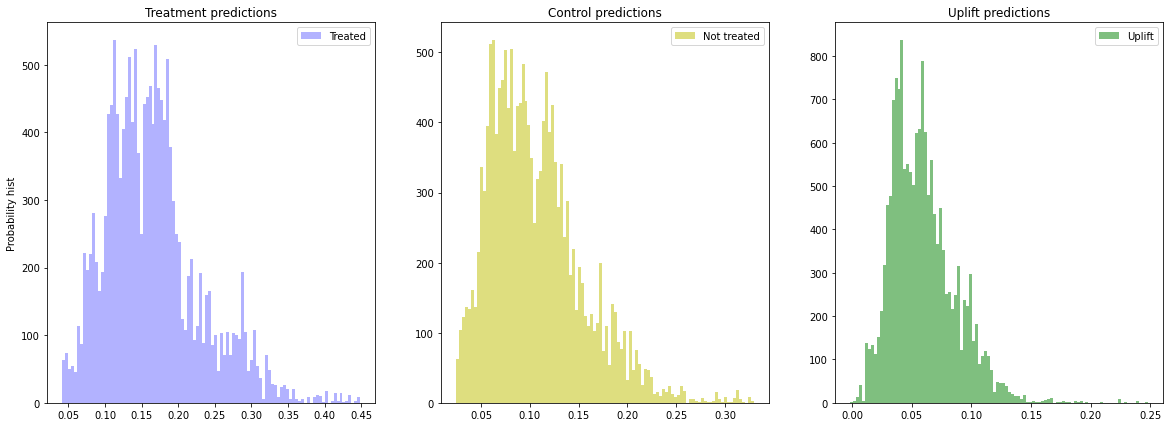

In [26]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=rnd_st, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

models_results['approach'].append('ClassTransformation')
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(ct_score)
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(ct_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
ct_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
ct_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=ct_trmnt_preds, ctrl_preds=ct_ctrl_preds);

__5.3 TwoModels__

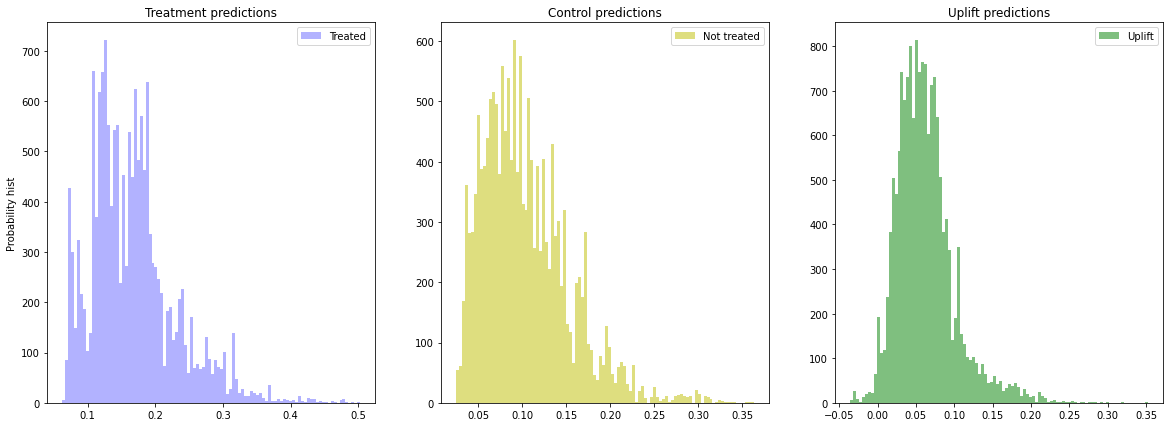

In [27]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=rnd_st, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=rnd_st, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

models_results['approach'].append('TwoModels')
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(tm_score)
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [28]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.08574740506373715, 0.07450620459301957, 0.08396812086448549],
 'uplift@20%': [0.0868786602778181, 0.08220142473082798, 0.08411279925727436]}

__Результаты сравнений моделей__ 'SoloModel', 'ClassTransformation', 'TwoModels'<br>
random_state = 1<br>
uplift@10%:   0.06935715948284982, 0.07693243614972808, 0.07970968492773864<br>
uplift@20%:   0.08459381088784831, 0.07515564387413193, 0.06158326903224215<br>
random_state = 13<br>
uplift@10%:   0.07956137000254646,
  0.059396485867074106,
  0.09180566165860284<br>
uplift@20%:   0.08653659200497744, 0.08764882846194094, 0.10060415164241575<br>
random_state = 17<br>
uplift@10%:   0.1104604413974058, 0.060856133223301384, 0.08346558327514336<br>
uplift@20%:   0.08635196127136471, 0.07748325529118705, 0.07898904591274078<br>
random_state = 42<br>
uplift@10%:   0.06828411811652035,
  0.05791433891992548,
  0.054828411811652045<br>
uplift@20%:   0.06343415542112613, 0.0531316891577478, 0.07225686365751513<br>
random_state = 123<br>
uplift@10%:   0.08574740506373715, 0.07450620459301957, 0.08396812086448549<br>
uplift@20%:   0.0868786602778181, 0.08220142473082798, 0.08411279925727436<br>

#### Вариант с деревом решений

In [29]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train[cat_features], prefix='gender')], 1)
features = [col for col in X_train_tree]

In [30]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml.inference'